# The Milwaukee Journal Sentinel and Life Expectancy

**Story:** [Race gap found in pothole patching](https://web.archive.org/web/20081223094123/http://www.jsonline.com/news/milwaukee/32580034.html)

**Author:** Keegan Kyle, Grant Smith and Ben Poston, Milwaukee Journal Sentinel

**Topics:** Census Data, Geocoding, QGIS Spatial Joins, Linear Regression

**Datasets**

* Pothole fill data from the Milwaukee [Department of Public Works](https://city.milwaukee.gov/dpw)
    - **2007-2010 POTHOLES.xls**: Pothole data, July 2007-July 2010
    - **2010-2013 POTHOLES.xls**: Pothole data, July 2010-July 2013
    - **2013-2017 POTHOLES.xls**: Pothole data, July 2013-July 2017
* **tl_2013_55_tract.zip:** 2013 census tract boundaries from the [US Census Bureau](https://www.census.gov/cgi-bin/geo/shapefiles/index.php)
* **addresses_geocoded.csv:** a large selection of addresses in Milwaukee, geocoded by [Geocod.io](https://geocod.io)
* **R12216099_SL140.csv:** ACS 2013 5-year, tract level, from [Social Explorer](https://www.socialexplorer.com)
    - Table A04001, Hispanic or Latino by Race
    - `R12216099.txt` is the data dictionary
* **R12216226_SL140.csv** ACS 2013 5-year, tract level, from [Social Explorer](https://www.socialexplorer.com)
    - Table A14006, 2013 Median Household income
    - Data dictionary [is here](https://www.socialexplorer.com/data/ACS2013_5yr/metadata/?ds=SE&table=A14006)

# What's the story?

We're trying to figure out if the **time it took Milwaukee to fill pot holes** is related to the racial makeup of a census tract.

# Do your imports

You'll also want to set pandas to display **up to 200 columns at a time**.

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

In [30]:
pd.set_option('display.max_columns', 200)

# Create a dataframe of potholes from only 2013

The delivered multiple files to us, so we'll need to filter them down to just 2013.

**Editorial decision:** When we say "a pothole from 2013," what exactly do we mean?

In [31]:
df=pd.read_excel('2010-2013 POTHOLES.xls')
df1 = pd.read_excel("2013-2017 POTHOLES.xls")

In [32]:
df.head(3)

,A,Street,EnterDt,PrintDt,ResolvDt
0,3839,N 10TH ST,2013-07-15 23:35,2013-07-16 05:46,2013-07-17 05:50
1,4900,W MELVINA ST,2013-07-15 20:05,2013-07-16 05:46,2013-07-24 16:58
2,2400,W WISCONSIN AV,2013-07-15 20:00,2013-07-16 05:56,2013-07-25 14:42


In [33]:
df1.head(3)

,A,Street,EnterDt,PrintDt,ResolvDt
0,7741,N 59TH ST,2017-07-15 08:55,2017-07-17 05:33,2017-07-21 04:51
1,5517,N 39TH ST,2017-07-14 22:36,2017-07-17 05:33,2017-07-25 15:29
2,8242,N GRANVILLE RD,2017-07-14 18:30,2017-07-17 05:33,2017-07-17 06:55


In [34]:
new = df[df.EnterDt.str.contains('2013', regex=True)|df.ResolvDt.str.contains('2013', regex=True)]
new1 = df1[df1.EnterDt.str.contains('2013', regex=True)|df1.ResolvDt.str.contains('2013', regex=True)]

In [35]:
final = new.append(new1)
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12857 entries, 0 to 48428
Data columns (total 5 columns):
A           12857 non-null int64
Street      12857 non-null object
EnterDt     12857 non-null object
PrintDt     11928 non-null object
ResolvDt    12849 non-null object
dtypes: int64(1), object(4)
memory usage: 602.7+ KB


## What is the maximum and minimum `EnterDt` and `ResolvDt`?

Use this to confirm that your date range is what you expected. If it isn't, take a look at what might have happened with your dataset.

* **Tip:** Missing data might be a headache

In [36]:
final=final.dropna()

In [37]:
final.EnterDt.max()

'2013-12-31 17:06'

In [38]:
final.ResolvDt.max()

'2014-01-23 17:05'

In [39]:
final.EnterDt.min()

'2012-12-17 10:10'

In [40]:
final.ResolvDt.min()

'2013-01-02 06:13'

In [42]:
final.head(3)

,A,Street,EnterDt,PrintDt,ResolvDt,time
0,3839,N 10TH ST,2013-07-15 23:35:00,2013-07-16 05:46:00,2013-07-17 05:50:00,1 days 06:15:00
1,4900,W MELVINA ST,2013-07-15 20:05:00,2013-07-16 05:46:00,2013-07-24 16:58:00,8 days 20:53:00
2,2400,W WISCONSIN AV,2013-07-15 20:00:00,2013-07-16 05:56:00,2013-07-25 14:42:00,9 days 18:42:00


## Calculate how long it took to fill potholes in 2013

Save it into a new column.

* **Tip:** It's possible to subtract two dates

In [44]:
final['EnterDt'] = pd.to_datetime(final.EnterDt)
final['ResolvDt'] = pd.to_datetime(final.ResolvDt)
final['PrintDt'] = pd.to_datetime(final.PrintDt)

final['time'] = final['ResolvDt'] - final['EnterDt']

#doing addresses
final['Number'] = final['A'].astype(str)
final['address1'] = final['Number'] + " " + final['Street']
final.head()


,A,Street,EnterDt,PrintDt,ResolvDt,time,Number,address1
0,3839,N 10TH ST,2013-07-15 23:35:00,2013-07-16 05:46:00,2013-07-17 05:50:00,1 days 06:15:00,3839,3839 N 10TH ST
1,4900,W MELVINA ST,2013-07-15 20:05:00,2013-07-16 05:46:00,2013-07-24 16:58:00,8 days 20:53:00,4900,4900 W MELVINA ST
2,2400,W WISCONSIN AV,2013-07-15 20:00:00,2013-07-16 05:56:00,2013-07-25 14:42:00,9 days 18:42:00,2400,2400 W WISCONSIN AV
3,1800,W HAMPTON AV,2013-07-15 19:55:00,2013-07-16 05:46:00,2013-07-18 06:06:00,2 days 10:11:00,1800,1800 W HAMPTON AV
4,4718,N 19TH ST,2013-07-15 19:50:00,2013-07-16 05:46:00,2013-08-02 06:08:00,17 days 10:18:00,4718,4718 N 19TH ST


### Hrm, well, I think we need that difference to be an integer

If your new column isn't an integer, create _another_ column that is.

* **Tip:** Just like you might use `.str.strip()` on a string column, if your column is a datetime you can use `.dt.components` to get the days, hours, minutes, seconds, etc of the column.

In [45]:
final['time'].dt.components
final[['days','hours','minutes','seconds','milliseconds','microseconds','nanoseconds']] = final['time'].dt.components
final.head(3)

,A,Street,EnterDt,PrintDt,ResolvDt,time,Number,address1,days,hours,minutes,seconds,milliseconds,microseconds,nanoseconds
0,3839,N 10TH ST,2013-07-15 23:35:00,2013-07-16 05:46:00,2013-07-17 05:50:00,1 days 06:15:00,3839,3839 N 10TH ST,1,6,15,0,0,0,0
1,4900,W MELVINA ST,2013-07-15 20:05:00,2013-07-16 05:46:00,2013-07-24 16:58:00,8 days 20:53:00,4900,4900 W MELVINA ST,8,20,53,0,0,0,0
2,2400,W WISCONSIN AV,2013-07-15 20:00:00,2013-07-16 05:56:00,2013-07-25 14:42:00,9 days 18:42:00,2400,2400 W WISCONSIN AV,9,18,42,0,0,0,0


# Read in your race-related census data

* **Tip:** This will probably give you an error the first time you try, because the Census Bureau doesn't think about the rest of the world.

In [46]:
df = pd.read_csv("R12216099_SL140.csv")
df

,Geo_FIPS,Geo_GEOID,Geo_NAME,Geo_QName,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,Geo_FILEID,Geo_LOGRECNO,Geo_US,Geo_REGION,Geo_DIVISION,Geo_STATECE,Geo_STATE,Geo_COUNTY,Geo_COUSUB,Geo_PLACE,Geo_PLACESE,Geo_TRACT,Geo_BLKGRP,Geo_CONCIT,Geo_AIANHH,Geo_AIANHHFP,Geo_AIHHTLI,Geo_AITSCE,Geo_AITS,Geo_ANRC,Geo_CBSA,Geo_CSA,Geo_METDIV,Geo_MACC,Geo_MEMI,Geo_NECTA,Geo_CNECTA,Geo_NECTADIV,Geo_UA,Geo_UACP,Geo_CDCURR,Geo_SLDU,Geo_SLDL,Geo_VTD,Geo_ZCTA3,Geo_ZCTA5,Geo_SUBMCD,Geo_SDELM,Geo_SDSEC,Geo_SDUNI,Geo_UR,Geo_PCI,Geo_TAZ,Geo_UGA,Geo_BTTR,Geo_BTBG,Geo_PUMA5,Geo_PUMA1,SE_A04001_001,SE_A04001_002,SE_A04001_003,SE_A04001_004,SE_A04001_005,SE_A04001_006,SE_A04001_007,SE_A04001_008,SE_A04001_009,SE_A04001_010,SE_A04001_011,SE_A04001_012,SE_A04001_013,SE_A04001_014,SE_A04001_015,SE_A04001_016,SE_A04001_017
0,55079000101,14000US55079000101,"Census Tract 1.01, Milwaukee County, Wisconsin","Census Tract 1.01, Milwaukee County, Wisconsin",wi,140,0,ACSSF,4717,NaN,NaN,NaN,NaN,55,79,NaN,NaN,NaN,101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5306,5015,1343,3567,13,70,0,16,6,291,37,0,0,0,0,254,0
1,55079000102,14000US55079000102,"Census Tract 1.02, Milwaukee County, Wisconsin","Census Tract 1.02, Milwaukee County, Wisconsin",wi,140,0,ACSSF,4718,NaN,NaN,NaN,NaN,55,79,NaN,NaN,NaN,102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3648,3549,1034,2195,36,118,0,0,166,99,67,32,0,0,0,0,0
2,55079000201,14000US55079000201,"Census Tract 2.01, Milwaukee County, Wisconsin","Census Tract 2.01, Milwaukee County, Wisconsin",wi,140,0,ACSSF,4719,NaN,NaN,NaN,NaN,55,79,NaN,NaN,NaN,201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4791,4019,1185,2657,0,102,0,0,75,772,120,0,0,0,0,613,39
3,55079000202,14000US55079000202,"Census Tract 2.02, Milwaukee County, Wisconsin","Census Tract 2.02, Milwaukee County, Wisconsin",wi,140,0,ACSSF,4720,NaN,NaN,NaN,NaN,55,79,NaN,NaN,NaN,202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6324,6148,2687,2810,87,390,12,0,162,176,113,0,0,0,0,63,0
4,55079000301,14000US55079000301,"Census Tract 3.01, Milwaukee County, Wisconsin","Census Tract 3.01, Milwaukee County, Wisconsin",wi,140,0,ACSSF,4721,NaN,NaN,NaN,NaN,55,79,NaN,NaN,NaN,301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1339,1339,1005,220,0,90,0,10,14,0,0,0,0,0,0,0,0
5,55079000302,14000US55079000302,"Census Tract 3.02, Milwaukee County, Wisconsin","Census Tract 3.02, Milwaukee County, Wisconsin",wi,140,0,ACSSF,4722,NaN,NaN,NaN,NaN,55,79,NaN,NaN,NaN,302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3091,2946,448,2363,11,40,0,0,84,145,74,25,0,0,0,34,12
6,55079000303,14000US55079000303,"Census Tract 3.03, Milwaukee County, Wisconsin","Census Tract 3.03, Milwaukee County, Wisconsin",wi,140,0,ACSSF,4723,NaN,NaN,NaN,NaN,55,79,NaN,NaN,NaN,303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2029,1980,864,941,0,77,0,0,98,49,25,0,0,0,0,24,0
7,55079000304,14000US55079000304,"Census Tract 3.04, Milwaukee County, Wisconsin","Census Tract 3.04, Milwaukee County, Wisconsin",wi,140,0,ACSSF,4724,NaN,NaN,NaN,NaN,55,79,NaN,NaN,NaN,304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3072,3024,1318,1140,0,445,0,38,83,48,36,0,0,0,0,12,0
8,55079000400,14000US55079000400,"Census Tract 4, Milwaukee County, Wisconsin","Census Tract 4, Milwaukee County, Wisco

## Create new dataframe describing the racial makeup of each census tract

Each row should contain:

* The census tract number
* The percent of the population that is White
* The percent of the population that is Black
* The percent of the population that is Hispanic
* The percent of the population that is a minority (non-White)

You can either calculate and filter on the original shapefile, or create a whole new dataframe.

* **Tip:** You'll want to read the data dictionary for the Census data.
* **Tip:** The column names don't exactly match the data dictionary, but you can figure it out
* **Tip:** If you aren't sure which column is the actual census tract number, you can keep multiples for now

In [47]:
race_df = pd.read_csv('R12216099_SL140.csv')

new_df = race_df[['Geo_TRACT','SE_A04001_001',
       'SE_A04001_003', 'SE_A04001_004','SE_A04001_010','Geo_FIPS']]

new_df = new_df.rename(columns={'Geo_TRACT':'census tract','SE_A04001_001':'Total Population', 
                        'SE_A04001_003':'Not Hispanic or Latino: White Alone', 
                        'SE_A04001_004':'Not Hispanic or Latino: Black or African American Alone', 
                        'SE_A04001_010':'Hispanic or Latino',})
new_df.head()

new_df['all minorities'] = (new_df['Hispanic or Latino'] + new_df['Not Hispanic or Latino: Black or African American Alone'])  / new_df['Total Population'] * 100
new_df['Not Hispanic or Latino: White Alone'] = (new_df['Not Hispanic or Latino: White Alone'] / new_df['Total Population']) * 100
new_df['Not Hispanic or Latino: Black or African American Alone'] = (new_df['Not Hispanic or Latino: Black or African American Alone'] / new_df['Total Population']) * 100
new_df['Hispanic or Latino'] = (new_df['Hispanic or Latino'] / new_df['Total Population']) * 100
new_df


,census tract,Total Population,Not Hispanic or Latino: White Alone,Not Hispanic or Latino: Black or African American Alone,Hispanic or Latino,Geo_FIPS,all minorities
0,101,5306,25.310969,67.225782,5.484357,55079000101,72.710139
1,102,3648,28.344298,60.169956,2.713816,55079000102,62.883772
2,201,4791,24.733876,55.458151,16.113546,55079000201,71.571697
3,202,6324,42.488931,44.433903,2.783049,55079000202,47.216951
4,301,1339,75.056012,16.430172,0.000000,55079000301,16.430172
5,302,3091,14.493691,76.447752,4.691038,55079000302,81.138790
6,303,2029,42.582553,46.377526,2.414983,55079000303,48.792509
7,304,3072,42.903646,37.109375,1.562500,55079000304,38.671875
8,400,2450,24.897959,56.489796,3.469388,55079000400,59.959184
9,501,3539,44.532354,40.576434,5.397005,55079000501,45.973439


# Combine this census data with your street address data

Create a new dataframe my merging your street addresses with your census data. It would be nice to marge on census tract code, but your addresses data does **not** have a census tract on them! **This is where things get a little crazy.**

### Adding census tract codes to addresses

We went ahead and geocoded many addresses in Milwaukee to create `addresses_geocoded.csv`. You'll need to add a new column using QGIS that adds in the address's census tract.

The QGIS command **Join attributes by location** will merge datasets that geographically overlap each other. If you have one layer that's a list of lat/lon points and one layer that's a shapefile with census tract information, **join attributes by location** can create a new layer of lat/lon points that also has census tract information.

You can export the result by right clicking the layer, selecting **Export As** and making sure the output is another CSV.

### Merging

Now you'll have three datasets:

* Addresses and pothole fill ties
* Census data according with census tract codes
* Addresses with census tract codes

You'll need to merge them each together to create one whole dataset.

In [48]:
geo = pd.read_csv("joined_layer.csv")
geo.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,address,city,state,Latitude,Longitude,Accuracy Score,Accuracy Type,Number,Street,City_1,State_1,County,Zip,Country,Source
0,55,79,21600,55079021600,216.0,Census Tract 216,G5020,S,3700105,0,42.952252,-87.924886,1846 W HALSEY AV,Milwaukee,Wisconsin,42.955054,-87.937461,1.0,rooftop,1846.0,W Halsey Ave,Milwaukee,WI,Milwaukee County,53221.0,US,City of Milwaukee
1,55,79,12800,55079012800,128.0,Census Tract 128,G5020,S,2699330,19352,43.031535,-88.030718,9324 W PARK HILL AV,Milwaukee,Wisconsin,43.033325,-88.029400,1.0,rooftop,9324.0,W Park Hill Ave,Milwaukee,WI,Milwaukee County,53226.0,US,City of Milwaukee
2,55,79,18300,55079018300,183.0,Census Tract 183,G5020,S,672421,0,42.991354,-87.892858,1020 E MANITOBA ST,Milwaukee,Wisconsin,42.989936,-87.896052,1.0,rooftop,1020.0,E Manitoba St,Milwaukee,WI,Milwaukee County,53207.0,US,City of Milwaukee
3,55,79,19600,55079019600,196.0,Census Tract 196,G5020,S,1303160,0,42.984657,-88.007697,3200 S 72ND ST,Milwaukee,Wisconsin,42.986515,-88.001719,1.0,rooftop,3200.0,S 72nd St,Milwaukee,WI,Milwaukee County,53219.0,US,City of Milwaukee
4,55,79,19800,55079019800,198.0,Census Tract 198,G5020,S,2062297,0,42.982079,-87.989733,6001 W WARNIMONT AV,Milwaukee,Wisconsin,42.979409,-87.987910,1.0,range_interpolation,6001.0,W Warnimont Ave,Milwaukee,WI,Milwaukee County,53220.0,US,TIGER/Line® dataset from the US Census Bureau


In [49]:
geo.NAME = geo.NAME.astype(int)

In [50]:
new_df = new_df.rename(columns={'census tract':'NAME'})
new_df.head()

,NAME,Total Population,Not Hispanic or Latino: White Alone,Not Hispanic or Latino: Black or African American Alone,Hispanic or Latino,Geo_FIPS,all minorities
0,101,5306,25.310969,67.225782,5.484357,55079000101,72.710139
1,102,3648,28.344298,60.169956,2.713816,55079000102,62.883772
2,201,4791,24.733876,55.458151,16.113546,55079000201,71.571697
3,202,6324,42.488931,44.433903,2.783049,55079000202,47.216951
4,301,1339,75.056012,16.430172,0.000000,55079000301,16.430172


In [26]:
merged = pd.merge(geo, new_df, left_on='GEOID', right_on='Geo_FIPS')
merged.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME_x,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,Zip,Country,Source,NAME_y,Total Population,Not Hispanic or Latino: White Alone,Not Hispanic or Latino: Black or African American Alone,Hispanic or Latino,Geo_FIPS,all minorities
0,55,79,21600,55079021600,216,Census Tract 216,G5020,S,3700105,0,...,53221.0,US,City of Milwaukee,21600,4327,60.203374,8.874509,20.268084,55079021600,29.142593
1,55,79,21600,55079021600,216,Census Tract 216,G5020,S,3700105,0,...,53221.0,US,City of Milwaukee,21600,4327,60.203374,8.874509,20.268084,55079021600,29.142593
2,55,79,21600,55079021600,216,Census Tract 216,G5020,S,3700105,0,...,53221.0,US,TIGER/Line® dataset from the US Census Bureau,21600,4327,60.203374,8.874509,20.268084,55079021600,29.142593
3,55,79,21600,55079021600,216,Census Tract 216,G5020,S,3700105,0,...,53221.0,US,TIGER/Line® dataset from the US Census Bureau,21600,4327,60.203374,8.874509,20.268084,55079021600,29.142593
4,55,79,21600,55079021600,216,Census Tract 216,G5020,S,3700105,0,...,53221.0,US,City of Milwaukee,21600,4327,60.203374,8.874509,20.268084,55079021600,29.142593


In [51]:
final = final.rename(columns={'A':'Number'})
final.head()

,Number,Street,EnterDt,PrintDt,ResolvDt,time,Number,address1,days,hours,minutes,seconds,milliseconds,microseconds,nanoseconds
0,3839,N 10TH ST,2013-07-15 23:35:00,2013-07-16 05:46:00,2013-07-17 05:50:00,1 days 06:15:00,3839,3839 N 10TH ST,1,6,15,0,0,0,0
1,4900,W MELVINA ST,2013-07-15 20:05:00,2013-07-16 05:46:00,2013-07-24 16:58:00,8 days 20:53:00,4900,4900 W MELVINA ST,8,20,53,0,0,0,0
2,2400,W WISCONSIN AV,2013-07-15 20:00:00,2013-07-16 05:56:00,2013-07-25 14:42:00,9 days 18:42:00,2400,2400 W WISCONSIN AV,9,18,42,0,0,0,0
3,1800,W HAMPTON AV,2013-07-15 19:55:00,2013-07-16 05:46:00,2013-07-18 06:06:00,2 days 10:11:00,1800,1800 W HAMPTON AV,2,10,11,0,0,0,0
4,4718,N 19TH ST,2013-07-15 19:50:00,2013-07-16 05:46:00,2013-08-02 06:08:00,17 days 10:18:00,4718,4718 N 19TH ST,17,10,18,0,0,0,0


In [88]:
merged1 = pd.merge(merged, final, left_on='address', right_on='address1')
merged1 = merged1.dropna()
merged1.shape

(11885, 49)

In [77]:
merged1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11885 entries, 0 to 11933
Data columns (total 49 columns):
STATEFP                                                    11885 non-null int64
COUNTYFP                                                   11885 non-null int64
TRACTCE                                                    11885 non-null int64
GEOID                                                      11885 non-null int64
NAME_x                                                     11885 non-null int64
NAMELSAD                                                   11885 non-null object
MTFCC                                                      11885 non-null object
FUNCSTAT                                                   11885 non-null object
ALAND                                                      11885 non-null int64
AWATER                                                     11885 non-null int64
INTPTLAT                                                   11885 non-null float64
INTPTL

# Linear regression

Using the `statsmodels` package, run a linear regression to find the coefficient relating percent minority and pothole fill times.

In [53]:
# !pip install --upgrade --no-deps statsmodels

     |████████████████████████████████| 10.5MB 9.3MB/s eta 0:00:01


,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME_x,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,address,city,state,Latitude,Longitude,Accuracy Score,Accuracy Type,Number_x,Street_x,City_1,State_1,County,Zip,Country,Source,NAME_y,Total Population,Not Hispanic or Latino: White Alone,Not Hispanic or Latino: Black or African American Alone,Hispanic or Latino,Geo_FIPS,all minorities,Number_y,Street_y,EnterDt,PrintDt,ResolvDt,time,Number_y,address1,days,hours,minutes,seconds,milliseconds,microseconds,nanoseconds
2811,55,79,5900,55079005900,59,Census Tract 59,G5020,S,850830,0,43.068211,-87.985236,5700 W LISBON AV,Milwaukee,Wisconsin,43.066167,-87.984018,1.0,range_interpolation,5700.0,W Lisbon Ave,Milwaukee,WI,Milwaukee County,53210.0,US,TIGER/Line® dataset from the US Census Bureau,5900,3557,20.494799,66.516728,8.012370,55079005900,74.529098,5700,W LISBON AV,2013-04-18 12:15:00,2013-04-18 13:29:00,2013-05-10 14:53:00,22 days 02:38:00,5700,5700 W LISBON AV,22,2,38,0,0,0,0
8087,55,79,1700,55079001700,17,Census Tract 17,G5020,S,1324195,0,43.108559,-88.016212,8644 W LANCASTER AV,Milwaukee,Wisconsin,43.110707,-88.021007,1.0,rooftop,8644.0,W Lancaster Ave,Milwaukee,WI,Milwaukee County,53225.0,US,City of Milwaukee,1700,4499,29.428762,65.859080,2.622805,55079001700,68.481885,8644,W LANCASTER AV,2013-11-19 14:24:00,2013-11-20 06:14:00,2013-11-20 14:41:00,1 days 00:17:00,8644,8644 W LANCASTER AV,1,0,17,0,0,0,0
7482,55,79,19500,55079019500,195,Census Tract 195,G5020,S,1310744,0,42.977332,-88.027722,3538 S 91ST ST,Milwaukee,Wisconsin,42.979706,-88.026183,1.0,range_interpolation,3538.0,S 91st St,Milwaukee,WI,Milwaukee County,53228.0,US,TIGER/Line® dataset from the US Census Bureau,19500,3601,89.141905,0.555401,8.247709,55079019500,8.803110,3538,S 91ST ST,2013-04-22 10:35:00,2013-04-23 16:01:00,2013-04-30 14:47:00,8 days 04:12:00,3538,3538 S 91ST ST,8,4,12,0,0,0,0
3813,55,79,18100,55079018100,181,Census Tract 181,G5020,S,576123,597091,42.998157,-87.885520,2657 S CLEMENT AV,Milwaukee,Wisconsin,42.996070,-87.894459,1.0,rooftop,2657.0,S Clement Ave,Milwaukee,WI,Milwaukee County,53207.0,US,City of Milwaukee,18100,1709,81.041545,4.330018,5.675834,55079018100,10.005851,2657,S CLEMENT AV,2013-05-02 14:00:00,2013-05-03 16:11:00,2013-05-06 15:24:00,4 days 01:24:00,2657,2657 S CLEMENT AV,4,1,24,0,0,0,0
8158,55,79,3700,55079003700,37,Census Tract 37,G5020,S,635345,0,43.085460,-87.983364,5200 W NASH ST,Milwaukee,Wisconsin,43.084256,-87.978467,1.0,range_interpolation,5200.0,W Nash St,Milwaukee,WI,Milwaukee County,53216.0,US,TIGER/Line® dataset from the US Census Bureau,3700,2239,8.619920,89.057615,0.223314,55079003700,89.280929,5200,W NASH ST,2013-11-18 14:18:00,2013-11-19 07:03:00,2013-11-19 15:05:00,1 days 00:47:00,5200,5200 W NASH ST,1,0,47,0,0,0,0


In [92]:
merged1['all minorities'].value_counts()

60.956765    203
76.343505    165
76.589836    147
70.436583    144
92.692496    142
47.216951    139
54.550767    138
79.069767    136
70.541761    133
29.764652    131
17.233977    126
15.879211    123
88.420146    123
76.365493    121
68.481885    115
62.883772    115
15.010246    113
98.201901    112
74.529098    112
92.028986    108
25.000000    107
69.953283    104
91.754757    103
86.782133    101
38.671875    100
55.529820     99
89.280929     98
80.556783     96
8.363202      94
19.706981     93
            ... 
84.531590     16
85.763589     15
68.684604     14
21.976325     14
31.994192     12
80.343980     10
14.455278      9
7.473842       9
23.043852      8
9.397163       8
4.782106       7
1.834862       6
16.773808      5
3.731778       5
8.232676       4
38.623006      3
21.718991      2
5.794948       2
22.199488      2
30.686872      2
17.679719      2
9.222462       2
4.739064       2
8.292683       2
33.495702      1
18.538024      1
34.477007      1
3.566194      

In [57]:
X = sm.add_constant(merged1[['all minorities']])

mod = sm.OLS(merged1['days'], X)
res = mod.fit()
res.summary()

/Users/lilyliu-krason/.pyenv/versions/3.7.1/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   days   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     65.61
Date:                Mon, 15 Jul 2019   Prob (F-statistic):           6.02e-16
Time:                        16:45:32   Log-Likelihood:                -46796.
No. Observations:               11885   AIC:                         9.360e+04
Df Residuals:                   11883   BIC:                         9.361e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              7.0418      0.243     28.954      0.000       6.565       7.519
all minorities     0.0305      0.004      8.100      0.000       0.023       0.038
==============================================================================
Omnibus:                     5782.125   Durbin-Watson:                   1.485
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32167.641
Skew:                           2.350   Prob(JB):                         0.00
Kurtosis:                       9.547   Cond. No.                         138.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Translate that into the form **"every X percentage point change in the minority population translates to a Y change in pot hole fill times"**

In [ ]:
# every 1 percentage point more in the minority population translates to a .0305 more of a day change in pot hole fill times"

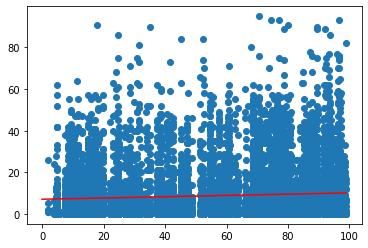

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(merged1["all minorities"], merged1["days"])
xs = range(0,100,1)
ys = [0.0305*x + 7.04 for x in xs]
plt.plot(xs, ys, color='red')

Do you feel comfortable that someone can understand that? Can you reword it to make it more easily understandable?

In [ ]:
# for every percentage of the population that is minority, a pot hole takes on average 44 minutes longer to fill"

# Other methods of explanation

While the regression is technically correct, it just does't sound very nice. What other options do we have?

## What's the average wait to fill a pothole between majority-white and majority-minority census tracts?

You'll need to create a new column to specify whether the census tract is majority White or not.

In [89]:
merged1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11885 entries, 0 to 11933
Data columns (total 49 columns):
STATEFP                                                    11885 non-null int64
COUNTYFP                                                   11885 non-null int64
TRACTCE                                                    11885 non-null int64
GEOID                                                      11885 non-null int64
NAME_x                                                     11885 non-null int64
NAMELSAD                                                   11885 non-null object
MTFCC                                                      11885 non-null object
FUNCSTAT                                                   11885 non-null object
ALAND                                                      11885 non-null int64
AWATER                                                     11885 non-null int64
INTPTLAT                                                   11885 non-null float64
INTPTL

In [85]:
# merged1=merged1.loc[merged1['all minorities']>.50, 'majority_minority'] = 1
# merged1=merged1.loc[merged1['all minorities']<=.50, 'majority_minority'] = 0

In [93]:
merged1['majority_white'] = merged1['all minorities'] < 50

In [97]:
merged1.groupby('majority_white').agg({'days':'mean'})

,days
majority_white,
False,9.590746
True,7.513303


In [95]:
merged1.sample(5, random_state=0)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME_x,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,address,city,state,Latitude,Longitude,Accuracy Score,Accuracy Type,Number_x,Street_x,City_1,State_1,County,Zip,Country,Source,NAME_y,Total Population,Not Hispanic or Latino: White Alone,Not Hispanic or Latino: Black or African American Alone,Hispanic or Latino,Geo_FIPS,all minorities,Number_y,Street_y,EnterDt,PrintDt,ResolvDt,time,Number_y,address1,days,hours,minutes,seconds,milliseconds,microseconds,nanoseconds,majority white,majority_white
2811,55,79,5900,55079005900,59,Census Tract 59,G5020,S,850830,0,43.068211,-87.985236,5700 W LISBON AV,Milwaukee,Wisconsin,43.066167,-87.984018,1.0,range_interpolation,5700.0,W Lisbon Ave,Milwaukee,WI,Milwaukee County,53210.0,US,TIGER/Line® dataset from the US Census Bureau,5900,3557,20.494799,66.516728,8.012370,55079005900,74.529098,5700,W LISBON AV,2013-04-18 12:15:00,2013-04-18 13:29:00,2013-05-10 14:53:00,22 days 02:38:00,5700,5700 W LISBON AV,22,2,38,0,0,0,0,False,False
8087,55,79,1700,55079001700,17,Census Tract 17,G5020,S,1324195,0,43.108559,-88.016212,8644 W LANCASTER AV,Milwaukee,Wisconsin,43.110707,-88.021007,1.0,rooftop,8644.0,W Lancaster Ave,Milwaukee,WI,Milwaukee County,53225.0,US,City of Milwaukee,1700,4499,29.428762,65.859080,2.622805,55079001700,68.481885,8644,W LANCASTER AV,2013-11-19 14:24:00,2013-11-20 06:14:00,2013-11-20 14:41:00,1 days 00:17:00,8644,8644 W LANCASTER AV,1,0,17,0,0,0,0,False,False
7482,55,79,19500,55079019500,195,Census Tract 195,G5020,S,1310744,0,42.977332,-88.027722,3538 S 91ST ST,Milwaukee,Wisconsin,42.979706,-88.026183,1.0,range_interpolation,3538.0,S 91st St,Milwaukee,WI,Milwaukee County,53228.0,US,TIGER/Line® dataset from the US Census Bureau,19500,3601,89.141905,0.555401,8.247709,55079019500,8.803110,3538,S 91ST ST,2013-04-22 10:35:00,2013-04-23 16:01:00,2013-04-30 14:47:00,8 days 04:12:00,3538,3538 S 91ST ST,8,4,12,0,0,0,0,True,True
3813,55,79,18100,55079018100,181,Census Tract 181,G5020,S,576123,597091,42.998157,-87.885520,2657 S CLEMENT AV,Milwaukee,Wisconsin,42.996070,-87.894459,1.0,rooftop,2657.0,S Clement Ave,Milwaukee,WI,Milwaukee County,53207.0,US,City of Milwaukee,18100,1709,81.041545,4.330018,5.675834,55079018100,10.005851,2657,S CLEMENT AV,2013-05-02 14:00:00,2013-05-03 16:11:00,2013-05-06 15:24:00,4 days 01:24:00,2657,2657 S CLEMENT AV,4,1,24,0,0,0,0,True,True
8158,55,79,3700,55079003700,37,Census Tract 37,G5020,S,635345,0,43.085460,-87.983364,5200 W NASH ST,Milwaukee,Wisconsin,43.084256,-87.978467,1.0,range_interpolation,5200.0,W Nash St,Milwaukee,WI,Milwaukee County,53216.0,US,TIGER/Line® dataset from the US Census Bureau,3700,2239,8.619920,89.057615,0.223314,55079003700,89.280929,5200,W NASH ST,2013-11-18 14:18:00,2013-11-19 07:03:00,2013-11-19 15:05:00,1 days 00:47:00,5200,5200 W NASH ST,1,0,47,0,0,0,0,False,False


## How does the average wait time to fill a pothole change as more minorities live in an area?

* **Tip:** Use `.cut` or `.qcut` to split the percent minority (or white) into a few different bins.

In [98]:
ser=merged1['all minorities']
merged1['pct_minority']=pd.cut(ser, bins=4,labels=['1','2','3','4'])

In [103]:
merged1.groupby('pct_minority').agg({'days':'mean'})

,days
pct_minority,
1,6.767881
2,8.845087
3,10.095705
4,9.299913


In [104]:
ser=merged1['all minorities']
merged1['pct_minority_2']=pd.qcut(ser, q=4,labels=['1','2','3','4'])

In [105]:
merged1.groupby('pct_minority_2').agg({'days':'mean'})

,days
pct_minority_2,
1,6.803030
2,9.805195
3,9.575093
4,9.009122


# Bonus: Income

`R12216226_SL140.csv` contains income data for each census tract in Wisconsin. Add it into your analysis.

If you run a multivariate regression also including income, how does this change things?